In [1]:
import torch
import numpy as np
import sys
import os

sys.path.append(os.getcwd()+'/../src/')
%load_ext autoreload
%autoreload 2

from attribute import *
from plot import *
from ppo_policy import *
from utils import *

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from stable_baselines3 import PPO

In [3]:
BASE_PATH = '../../initial_model'

In [4]:
model = PPO.load(f'{BASE_PATH}/ppo/CnnPolicy/ppo_CnnPolicy.zip')
X = np.load(f'{BASE_PATH}/ppo/CnnPolicy/observations.npy')
X = torch.Tensor(X)
X.shape

torch.Size([1448, 1, 1, 15, 7])

In [5]:
predictions = []
for _ in X:
    predictions.append(model.predict(X[0])[0][0])
predictions = np.array(predictions)

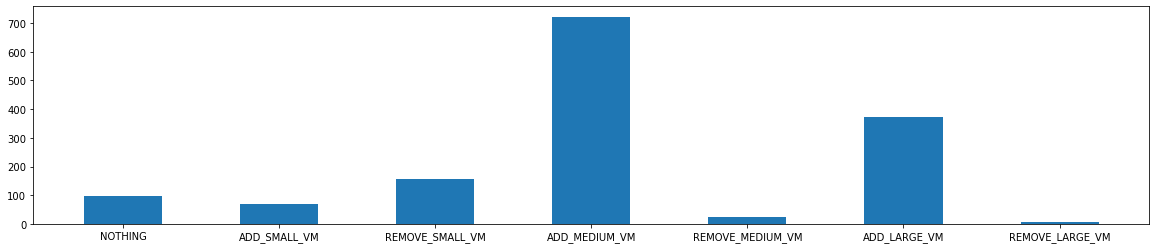

In [6]:
plot_action_histogram(predictions)

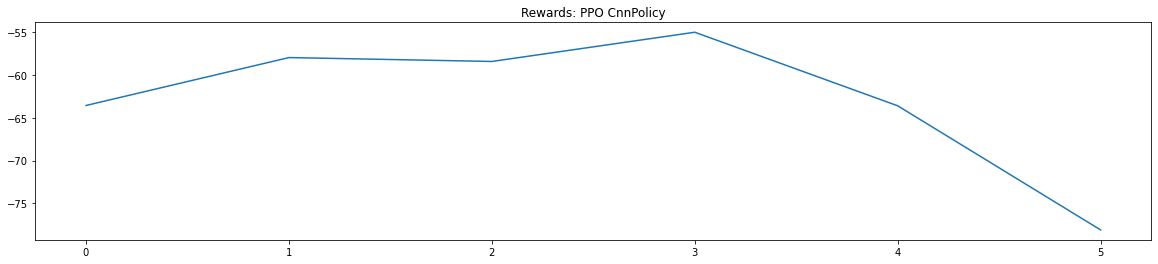

In [23]:
plot_training_data(f'{BASE_PATH}/ppo/CnnPolicy/training_data.csv', data_type='reward', title='PPO CnnPolicy')

In [24]:
df = parse_tensorboard(path='../../output_models_initial/ppo/CnnPolicy/PPO_130', scalars=['rollout/ep_rew_mean'])
plt.plot(df['rollout/ep_rew_mean']['step'], df['rollout/ep_rew_mean']['value'])

DirectoryDeletedError: Directory ../../output_models_initial/ppo/CnnPolicy/PPO_130 has been permanently deleted

In [7]:
from ppo_policy import PPOPolicy
ppo_net = PPOPolicy(model.observation_space, model.action_space, model.lr_schedule, model)

In [8]:
x = torch.tensor(X[10])
ppo_net.forward(x)

/Users/amalota/anaconda3/envs/py37_trainloop/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


tensor([[-17.3899]], grad_fn=<AddmmBackward0>)

In [10]:
import shap

X_squeezed = torch.squeeze(X, dim=1)
# we use the first 100 training examples as our background dataset to integrate over
N = 100
idxs = np.random.choice(np.arange(X_squeezed.shape[0]), size=N)
X_sample = X[:N]
predictions_sample = predictions[:N]

explainer = shap.DeepExplainer(ppo_net, X_sample)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [100, 1, 1, 15, 7]

In [ ]:
x_test = X[N:N+10]

shap_values = explainer.shap_values(x_test)

shap.force_plot(explainer.expected_value, shap_values, x_test[0])
# shap.summary_plot(shap_values, x_test, Utils.FEATURE_NAMES)

In [26]:
N = 500
idxs = np.random.choice(np.arange(X.shape[0]), size=N)

X_sample = X[idxs]
predictions_sample = predictions[idxs]

X_sample = X[N+40:2*(N+40)]
predictions_sample = predictions[N+40:2*(N+40)]

ig_attributor = IGAttributor(net=ppo_net,
                            policy='cnn',
                            agent='ppo',
                            data=X_sample,
                            predictions=predictions_sample)

Action made: ADD_MEDIUM_VM


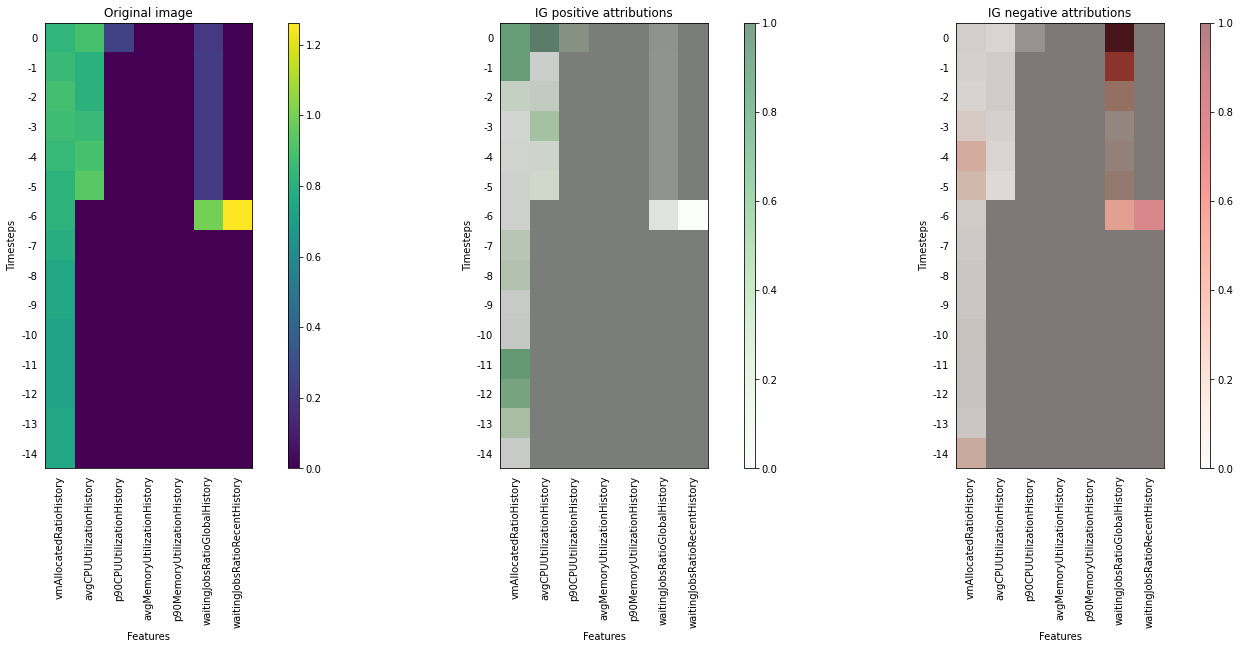

In [27]:
ig_attributor.explain_example(8)

Action made: ADD_LARGE_VM


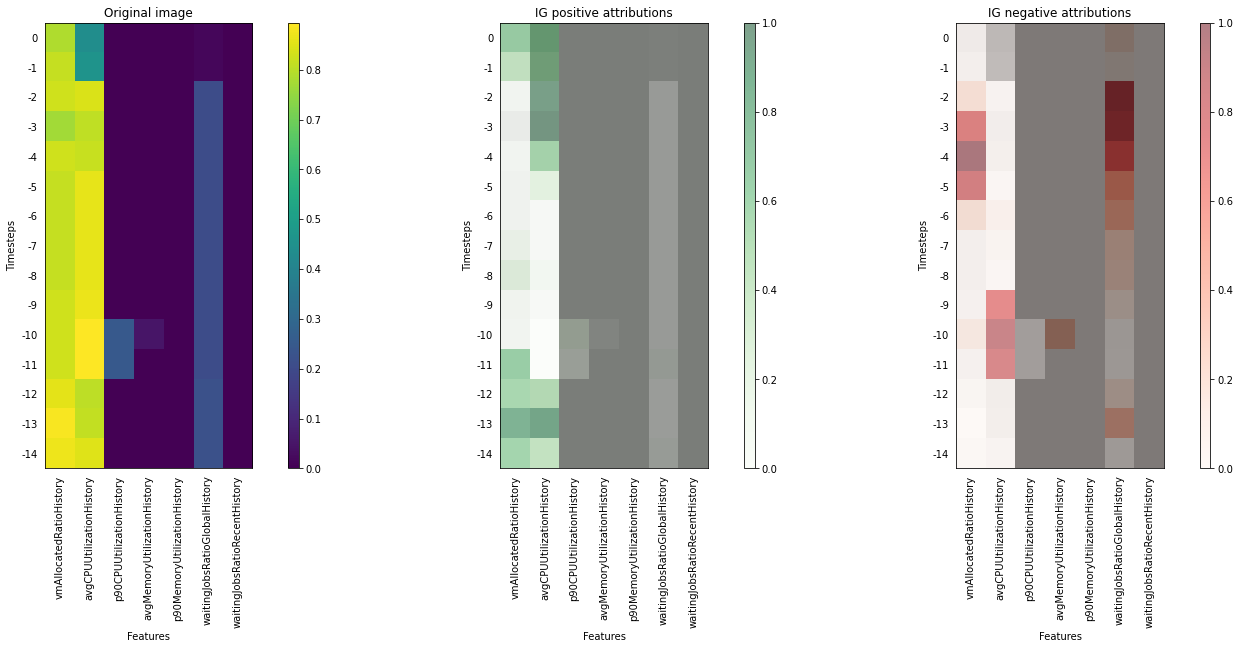

In [28]:
ig_attributor.explain_example(19)

In [16]:
action_observation_map = get_action_observation_map(predictions)

Observation count for each action:
{'ADD_LARGE_VM': 386,
 'ADD_MEDIUM_VM': 729,
 'ADD_SMALL_VM': 76,
 'NOTHING': 65,
 'REMOVE_LARGE_VM': 5,
 'REMOVE_MEDIUM_VM': 17,
 'REMOVE_SMALL_VM': 170}


In [14]:
idx = action_observation_map['REMOVE_SMALL_VM'].squeeze(1)[:500]

In [15]:
ig_attributor = IGAttributor(net=ppo_net,
                            policy='cnn',
                            agent='ppo',
                            data=X[idx],
                            predictions=predictions[idx])

Action made: REMOVE_SMALL_VM


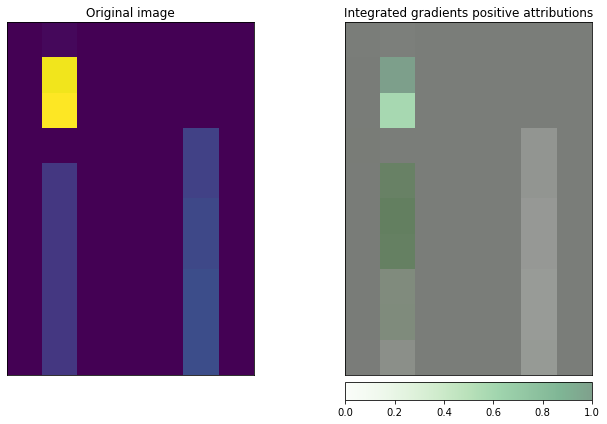

In [16]:
ig_attributor.explain_example(idx=1)

In [17]:
X_manual = torch.Tensor([[[
    [[0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1]],
    # [[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]],
    # [[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]]
    ]]])

predictions_manual = []
for _ in X_manual:
    predictions_manual.append(model.predict(X_manual[0])[0][0])
predictions_manual = np.array(predictions_manual)

In [25]:
X_manual.shape

torch.Size([1, 1, 1, 10, 7])

In [18]:
ig_attributor = IGAttributor(net=ppo_net,
                            policy='cnn',
                            agent='ppo',
                            data=X_manual,
                            predictions=predictions_manual)

Action made: REMOVE_LARGE_VM


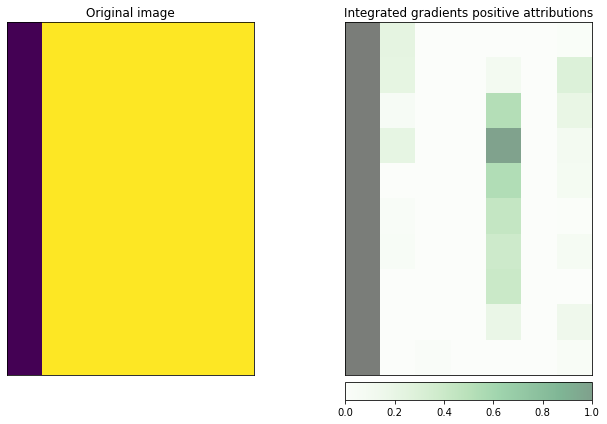

In [20]:
ig_attributor.explain_example(idx=0)

In [21]:
ig_attributor.explain_example(idx=1)

IndexError: index 1 is out of bounds for dimension 0 with size 1